#Access Data set from kaggle

In [1]:
!pip install kaggle


In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [6]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 87% 129M/149M [00:00<00:00, 1.33GB/s]
100% 149M/149M [00:00<00:00, 1.25GB/s]


#Import the dependiences

In [7]:
import os          # For directory and file operations
import numpy as np  # For numerical operations and handling image arrays
import random   # For generating random values for augmentation
from PIL import Image, ImageEnhance   # For image processing and enhancement
from tensorflow.keras.preprocessing.image import load_img   # For loading images
from tensorflow.keras.models import Sequential    # For building the model
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense    # For model layers
from tensorflow.keras.optimizers import Adam    # For optimizer
from tensorflow.keras.applications import VGG16   # For using VGG16 model
from sklearn.utils import shuffle   # For shuffling the data

#Load Datasets

In [9]:
!ls

brain-tumor-mri-dataset.zip  kaggle.json  sample_data


In [10]:
#extractiong the compessed dataset

from zipfile import ZipFile
dataset = '/content/brain-tumor-mri-dataset.zip'

with ZipFile(dataset, 'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


In [11]:
!ls

brain-tumor-mri-dataset.zip  kaggle.json  sample_data  Testing	Training


In [13]:
#Directories for trainin and testing dataset
train_dir = '/content/Training'
test_dir = '/content/Testing'

#load and shuffle the train data
train_paths = []
train_labels = []
for label in os.listdir(train_dir):
  for image in os.listdir(os.path.join(train_dir, label)):
    train_paths.append(os.path.join(train_dir, label, image))
    train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)


In [14]:
#load and shuffle test data
test_paths = []
test_labels = []
for label in os.listdir(test_dir):
  for image in os.listdir(os.path.join(test_dir, label)):
    test_paths.append(os.path.join(test_dir, label, image))
    test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

#Data Visualization

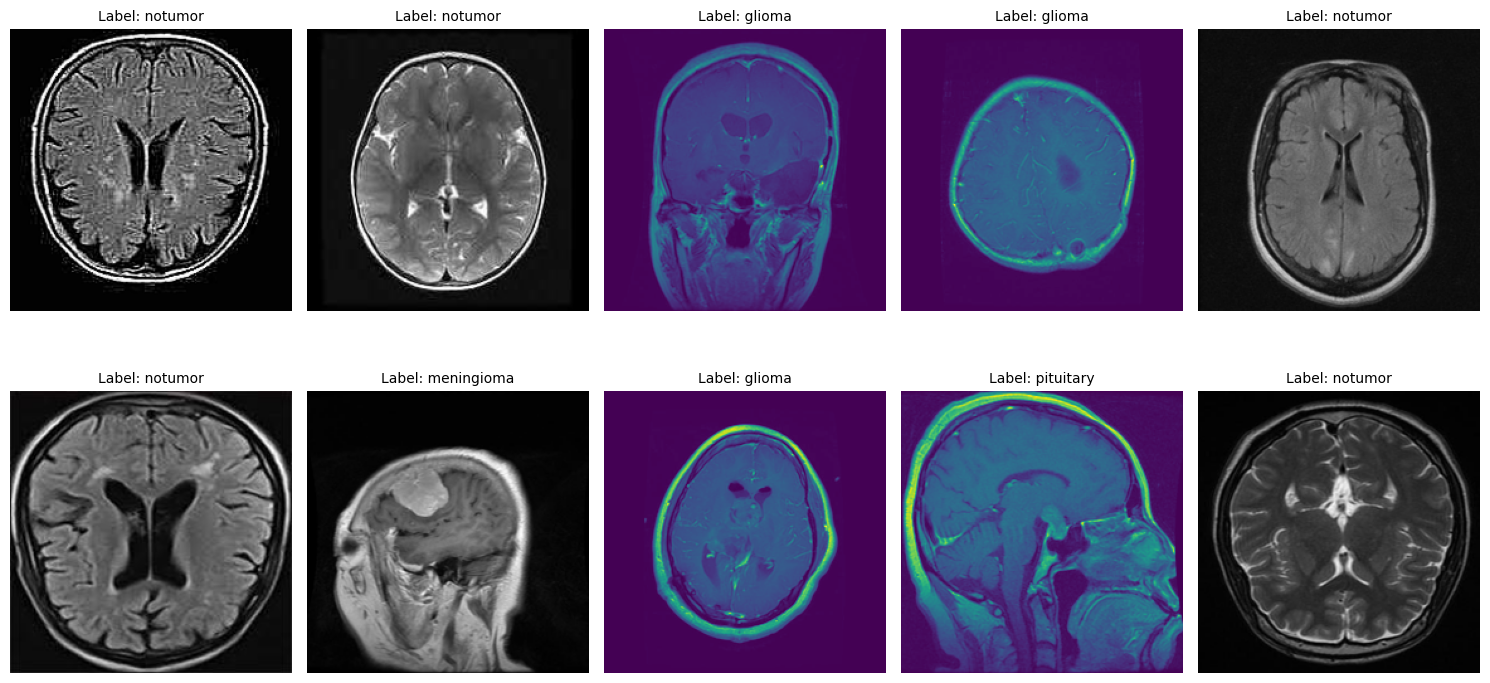

In [16]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import os

#select random indices for 10 images
random_indices = random.sample(range(len(train_paths)), 10)

#create a figure to display images in 2 rows
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
  #load image
  img_path = train_paths[idx]
  img = Image.open(img_path)
  img = img.resize((224, 224))   #resize to consistent size

  #display images
  axes[i].imshow(img)
  axes[i].axis('off')
  #display class label in the jsecond row
  axes[i].set_title(f"Label: {train_labels[idx]}", fontsize=10)


plt.tight_layout()
plt.show()


#Image Preprocessing

In [17]:
IMAGE_SIZE = 128  # Image size (adjust based on your requirements)

In [35]:
# Image Augmentation functon
def augment_image(image):
  image = Image.fromarray(np.uint8(image))
  # Correctly apply Brightness and Contrast enhancement
  enhancer_brightness = ImageEnhance.Brightness(image)
  image = enhancer_brightness.enhance(random.uniform(0.8, 1.2))  # Random brightness
  enhancer_contrast = ImageEnhance.Contrast(image)
  image = enhancer_contrast.enhance(random.uniform(0.8, 1.2))  # Random contrast
  image = np.array(image) / 255.0     # Normalized pixel [0 to 1] and load in numpy array
  return image

# Load images and apply augmentation
def open_images(paths):
  images = []
  for path in paths:
    image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    image = augment_image(image)
    images.append(image)
  return np.array(images)



# Encoding labels (convert label names to integers)
def encode_labels(labels):
  unique_labels = os.listdir(train_dir) # Ensure unique labels are determined
  encode = [unique_labels.index(label) for label in labels]
  return np.array(encode) # Corrected typo: np.arrray to np.array


# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
  for _ in range(epochs):
    for i in range(0, len(paths), batch_size):
      batch_paths = paths[i:i + batch_size]
      batch_images = open_images(batch_paths)  # Open and augment images

      batch_labels = labels[i:i + batch_size]
      batch_labels = encode_labels(batch_labels)  # Encode labels

      yield batch_images, batch_labels

# MODEL:

## WE ARE USING VGG16 FOR TRANSFER LEARNING.


In [36]:
# Model architecture

base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

#Freeze all layers of the VGG16 base model
for layer in base_model.layers:
  layer.trainable = False


# Set the laset few layers of the VGG16 base model to be trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Build the final model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(base_model)  #add VGG16 base model
model.add(Flatten())  # Flattent the output of the base model
model.add(Dropout(0.3))  #Dropout layer for regularization
model.add(Dense(128, activation='relu'))  # Dense layer with Relu activation
model.add(Dropout(0.2))  #Dropout layer for regularization
model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))  # Output layer

In [37]:
# Compile the model
model.compile(
    optimizer = Adam(learning_rate=0.0001),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['sparse_categorical_accuracy'] # Corrected the typo here
)

In [38]:
#Parameters
batch_size = 20
steps = int(len(train_paths) / batch_size)
epochs = 10

In [39]:
#Train the model
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 26s 59ms/step - loss: 0.6407 - sparse_categorical_accuracy: 0.7460
Epoch 2/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 22s 59ms/step - loss: 0.2545 - sparse_categorical_accuracy: 0.9129
Epoch 3/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 17s 59ms/step - loss: 0.1392 - sparse_categorical_accuracy: 0.9509
Epoch 4/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 17s 60ms/step - loss: 0.1078 - sparse_categorical_accuracy: 0.9605
Epoch 5/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - loss: 0.0844 - sparse_categorical_accuracy: 0.9662
Epoch 6/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 17s 59ms/step - loss: 0.0794 - sparse_categorical_accuracy: 0.9714
Epoch 7/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 17s 60ms/step - loss: 0.0427 - sparse_categorical_accuracy: 0.9869
Epoch 8/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - loss: 0.0431 - sparse_categorical_accuracy: 0.9830
Epoch 9/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 17s 59ms/step - loss: 0.0354 - sparse_categorical_accuracy: 0.9866
Epoch 10/10
285/285 ━━━━━━━━━━━━━━━━━

#Train and Validation plot

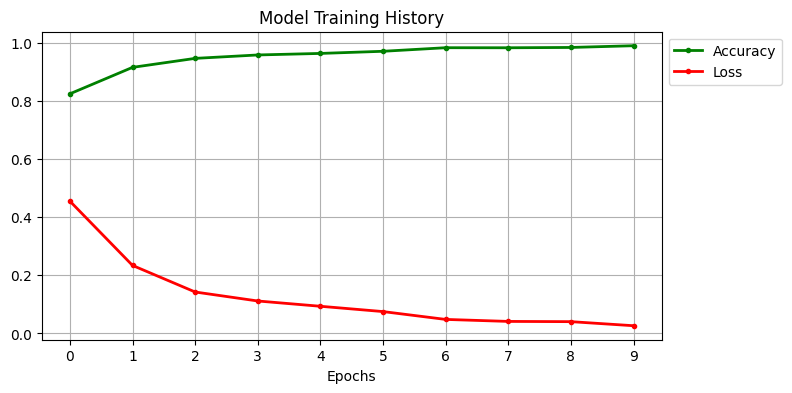

In [41]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('Epochs')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

#Model Classification Report

In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import numpy as np


In [45]:
# 1. Prediction on test data
test_images = open_images(test_paths)
test_labels_encode = encode_labels(test_labels)

# Prediction using the trained model
test_predictions = model.predict(test_images)

41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 174ms/step


In [46]:
# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encode, np.argmax(test_predictions, axis=1)))

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       300
           1       0.99      0.92      0.95       306
           2       1.00      1.00      1.00       405
           3       0.99      0.99      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.97      0.97      1311
weighted avg       0.98      0.98      0.98      1311



#Model Confusion Plot

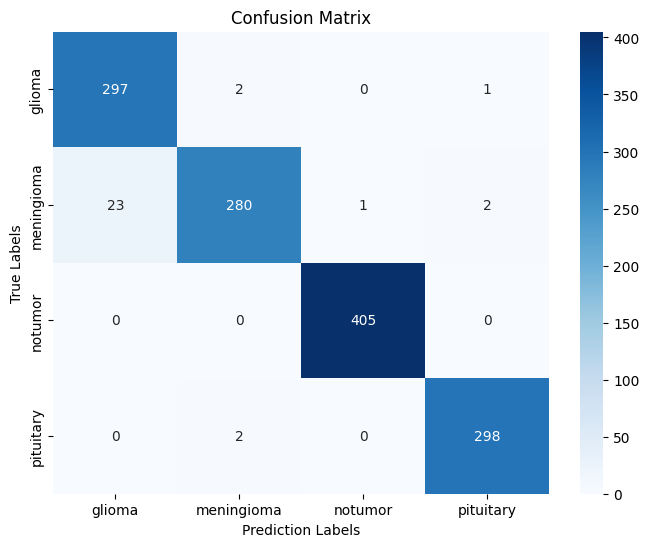

In [47]:
# 3. Confusion Matrix
conf_matrix = confusion_matrix(test_labels_encode, np.argmax(test_predictions, axis=1))

#plot the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Prediction Labels")
plt.ylabel("True Labels")
plt.show()

#ROC curve plot

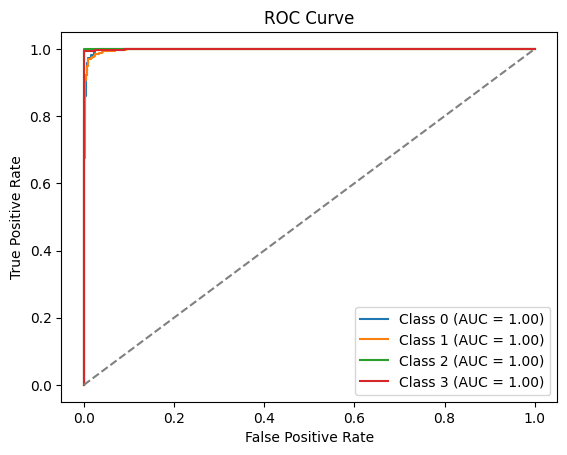

In [48]:
#binarize the test labels and predictions for multi class ROC
test_labels_bin = label_binarize(test_labels_encode, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions

#compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
  fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

#plot roc curve
for i in range(len(os.listdir(train_dir))):
  plt.plot(fpr[i],tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')


plt.plot([0, 1], [0,1], linestyle='--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

#Save and Load Model

In [49]:
#save the model
model.save('Brain_tumor_Detection_model.h5')

In [50]:
from tensorflow.keras.models import load_model
#load the train model
mmodel = load_model('Brain_tumor_Detection_model.h5')

#MRI tumor detection system

In [51]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Class labels
class_labels = ['pituitary', 'glioma', 'notumor', 'meningioma']

def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


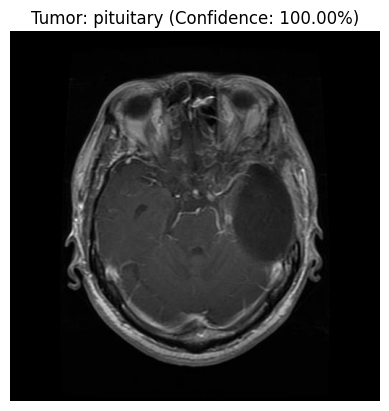

In [52]:
# Example usage
image_path = '/content/Te-gl_0015.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


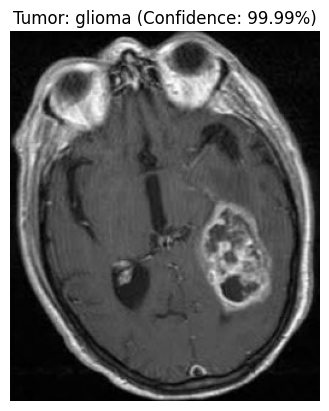

In [53]:
# Example usage
image_path = '/content/Te-meTr_0001.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


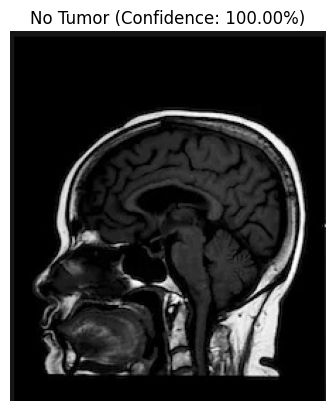

In [54]:
# Example usage
image_path = '/content/Te-noTr_0004.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


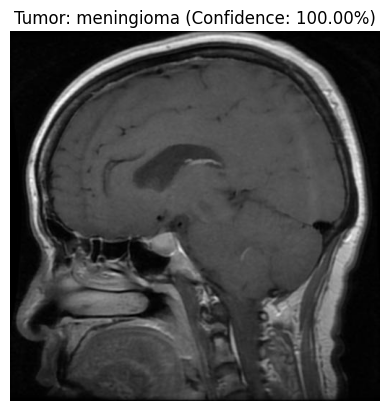

In [55]:
# Example usage
image_path = '/content/Te-piTr_0003.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)